# Dataset_Maker_Lines_and_Junctions

### Description:

Script to create dataset of lines and junctions and uniform regions.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import os
import pickle, os
from PIL import Image
import nbimporter

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def make_random_line_set(num_samples,R,dev,zero_center,delta=.25,eta=0.005):

    y, x = torch.meshgrid([torch.linspace(-1.0, 1.0, R, device=dev),
                               torch.linspace(-1.0, 1.0, R, device=dev)],indexing='ij')

    # Randomly generate angle, center is automatically (0,0) — but can eventually be modified
    
    if zero_center:
        jcenter = torch.zeros(num_samples,2).to(dev)
    else: 
        jcenter = (torch.rand(num_samples,2)*.8-.4).to(dev)
        # within [-.4,.4] 40% of the center
#         jcenter = (torch.rand(num_samples,2)*1.5-.75).to(dev)
        
    jangle = 2*np.pi*torch.rand(num_samples,1).to(dev)
    
    # Concatenate to form full set of parameters [output 4]
    params = torch.cat([jangle,jcenter],dim=1).unsqueeze(2).unsqueeze(3)

    # Define the three parameters
    angle = params[:, 0, :, :]   # shape [N, 1, 1, H', W']
    x0 = params[:, 1, :, :]   # shape [N, 1, 1, H', W']
    y0 = params[:, 2, :, :]   # shape [N, 1, 1, H', W']

    # Convert the angle into a and b
    a = -torch.sin(angle)
    b = torch.cos(angle)
    c = -y0*torch.cos(angle)+x0*torch.sin(angle)

    # Create distance functions and then stack to create dists [output 1]
    dist1 = a*x + b*y + c
    dist2 = -(a*x + b*y + c)
    dists = torch.stack([dist1, dist2], dim=1)
    
    # Apply smooth Heaviside function to distance functions
    hdists = 0.5 * (1.0 + (2.0 / np.pi) * torch.atan(dists / eta))
    
    # Convert Heaviside functions into wedge indicator functions [output 2]
    wedges = torch.stack([1.0 - hdists[:, 0, :, :],
                              hdists[:, 0, :, :] * (1.0 - hdists[:, 1, :, :]),
                              hdists[:, 0, :, :] *        hdists[:, 1, :, :]], dim=1)
    
    # Convert the heavyside distance functions into a boundary map
    d1 = hdists[:, 0, :, :]
    d2 = hdists[:, 1, :, :]
    
    minabsdist = torch.where(d1 < 0.0, -d1, torch.where(d2 < 0.0, torch.min(d1, -d2), torch.min(d1, d2)))

    boundaries = 1.0 / (1.0 + (minabsdist / delta) ** 2)

    return dists,wedges,boundaries,params

def make_grey_transform_lines(num_images,wedges,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([.5,1],device=dev).unsqueeze(0).repeat(num_images,1).unsqueeze(2).unsqueeze(3)

    if opt == 1:  

        grey_transform = torch.zeros((wedges.shape[0],2,1,1),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<wedges.shape[0]:
            
            sample = torch.rand(2).sort()[0]

            if torch.min(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(1).unsqueeze(1)

            num_grey_schemes += 1

        return grey_transform

In [27]:
def make_random_junction_set(num_samples,img_size,center_range,opts,dev,eta=.01,delta=.02):

#     img_size = 64
    img = np.zeros((img_size,img_size,1))

    opts.R                        = img_size
    opts.stride                   = img_size
    opts.eta                      = 0.01
    opts.delta                    = 0.02
    opts.lr_angles                = 0.003
    opts.lr_x0y0                  = 0.03
    opts.lambda_boundary_final    = 0.5
    opts.lambda_color_final       = 0.1
    opts.nvals                    = 31
    opts.num_initialization_iters = 30
    opts.num_refinement_iters     = 1000
    opts.greedy_step_every_iters  = 50
    opts.parallel_mode            = True

#     dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    foj = FieldOfJunctions(img, dev, opts)

    # Bounds of image: [-1,1],[-1,1]
    # Randomly generate junction location from [-3,3],[3,3] and 3 angles between [0,2*pi]

#     jcenter = 2*torch.rand(num_samples,2) - 1
#     jangles = 2*np.pi*torch.rand(num_samples,3) - np.pi
    jangles = 2*np.pi*torch.sort(torch.rand(num_samples,3))[0].to(dev)
#     jcenter = .9*torch.rand(num_samples,2).to(device) - .9

    jcenter = (center_range*torch.rand(num_samples,2) - center_range).to(dev)

    params = torch.cat([jangles,jcenter],dim=1).unsqueeze(2).unsqueeze(3)
    
    dists = foj.params2dists(params)
    wedges = foj.dists2indicators(dists).squeeze(-1).squeeze(-1)


    return dists,wedges,params,foj


def make_grey_transform_junc(num_images,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([0,.5,1]).unsqueeze(0).unsqueeze(2).unsqueeze(2)

    if opt == 1:  

        grey_transform = torch.zeros((num_images,3,1,1),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<num_images:
            
            sample = torch.rand(3,device=dev).sort()[0]

            if torch.min(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(1).unsqueeze(1)

            num_grey_schemes += 1

        return grey_transform

torch.Size([100, 3, 12, 12])


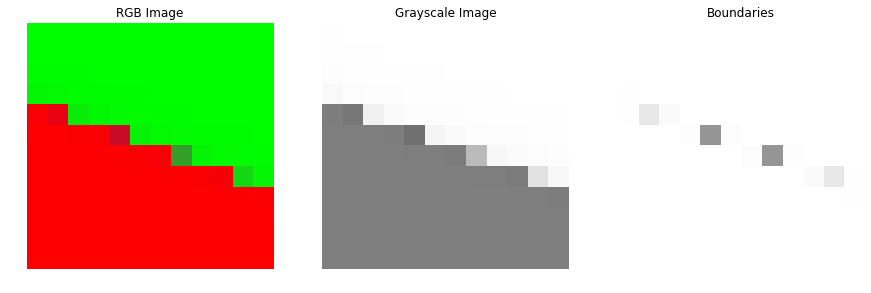

In [20]:
num_samples = 100
R = 12
    
dists,wedges,boundaries,params = make_random_line_set(num_samples,R,dev,1,delta=.25)#,eta=0.005)

print(wedges.shape)

grey_transform = make_grey_transform_lines(num_samples,wedges,dev,opt=0)

wedges_grey = (wedges[:,:2,:,:]*grey_transform).sum(1).squeeze(1)


img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

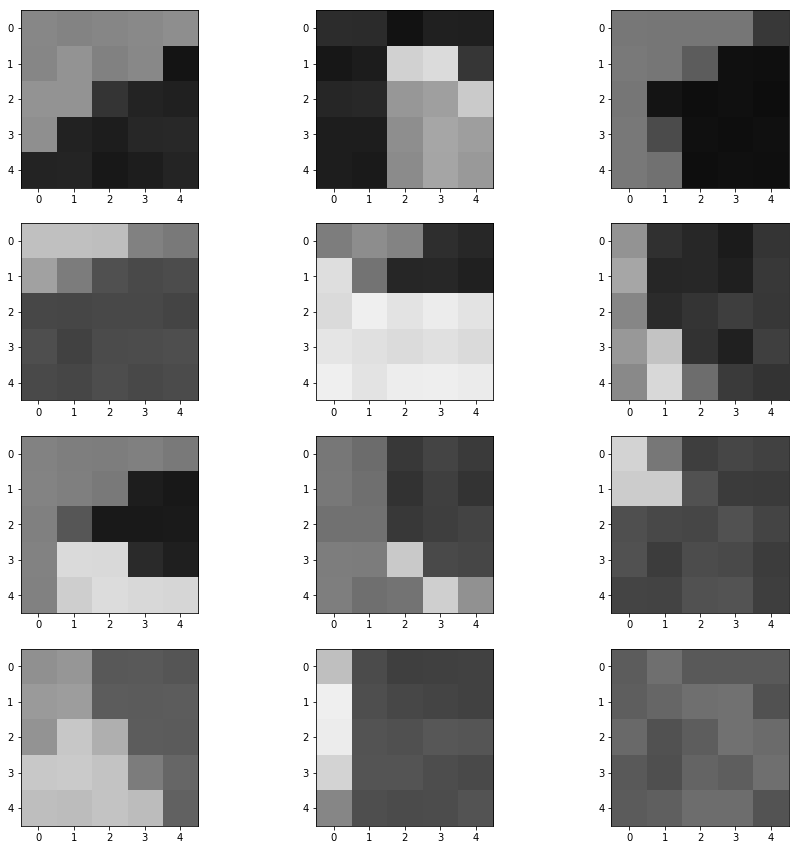

In [30]:
# Create a basic line dataset with

# R = 16,8
# 100,000 images
# colors = [.5,1]
# Noise added — RANDOM AMOUNTS
# NOT centered

# A pickle file containing:
# wedges
# wedges grey
# params
# boundaries

num_samples = 100
num_samples_orig = 100
R = 5
add_noise = 1
centered = 0

dists,wedges,boundaries,params = make_random_line_set(num_samples,R,'cpu',centered);
grey_transform = make_grey_transform_lines(num_samples,wedges,'cpu',1);

wedges_grey = (wedges[:,:2,:,:]*grey_transform).sum(1).unsqueeze(1)

add_solid = 1
if add_solid:
    
    num_samples_add = round(.25*num_samples_orig)

    
    wedges = torch.cat((wedges,torch.ones(num_samples_add,3,5,5)*torch.rand(num_samples_add).unsqueeze(1).unsqueeze(1).unsqueeze(1)),dim=0);
    wedges_grey = torch.cat((wedges_grey,torch.ones(num_samples_add,1,5,5)*torch.rand(num_samples_add).unsqueeze(1).unsqueeze(1).unsqueeze(1)),dim=0)
    boundaries = torch.cat((boundaries.unsqueeze(1),torch.ones(num_samples_add,1,5,5)),dim=0);
    params = torch.cat((params,torch.ones(num_samples_add,3,1,1)*torch.tensor((0,10,10)).reshape(1,3,1,1)),dim=0)
    
    num_samples += num_samples_add
    
add_junctions = 1
center_range = 1
if add_junctions:
    
    num_samples_add = round(.1*num_samples_orig)

    opts = SimpleNamespace();
    dists,junction_wedges,_,foj = make_random_junction_set(num_samples_add,R,center_range,opts,'cpu');
    
    grey_transform = make_grey_transform_junc(num_samples_add,'cpu',opt=1);

    junction_wedges_grey = (junction_wedges*grey_transform).sum(1).unsqueeze(1)
    junction_boundaries = foj.dists2boundaries(dists).squeeze(1).squeeze(3).squeeze(3).unsqueeze(1)


    wedges = torch.cat((wedges,junction_wedges),dim=0)
    wedges_grey = torch.cat((wedges_grey,junction_wedges_grey),dim=0)
    boundaries = torch.cat((boundaries,junction_boundaries),dim=0)
    params = torch.cat((params,torch.ones(num_samples_add,3,1,1)*torch.tensor((0,10,10)).reshape(1,3,1,1)),dim=0)

    
    num_samples += num_samples_add
    

if add_noise:
    wedges_grey = wedges_grey + .2*torch.rand(num_samples).unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape)#,device=dev)
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn)

    
line_data = {'wedges':wedges,
                 'wedges_grey':wedges_grey,
                 'params': params,
                 'boundaries':boundaries}

data_folder = 'Data/grayscale_lines/'

# if folder doesn't exist, make it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# with open(data_folder + 'line_data_5_100000_grey_multicolor_with_solid_with_junc_noiseless_uncentered.pkl', 'wb') as f:
#     pickle.dump(line_data, f)

plt.figure(figsize=[15, 15])

for ii in range(12):

    plt.subplot(4,3,ii+1)
    plt.imshow(wedges_grey[-ii,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
    

# plt.figure(figsize=[15, 15])

# for ii in range(12):
    
#     plt.subplot(4,3,ii+1)
#     plt.imshow(wedges[-ii,:,:].squeeze().cpu().permute(1,2,0))
# #     print(params[-ii,:])

